In [1]:
import pandas as pd
machine_data=pd.read_csv('/Users/test/Desktop/manufacture/manufacturing_6G_dataset.csv')
machine_data['Timestamp']=pd.to_datetime(machine_data['Timestamp'])

/var/folders/qk/pzgy59jd4ylbx86k8802qc9c0000gn/T/ipykernel_30902/210029010.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_data['Timestamp']=pd.to_datetime(machine_data['Timestamp'])


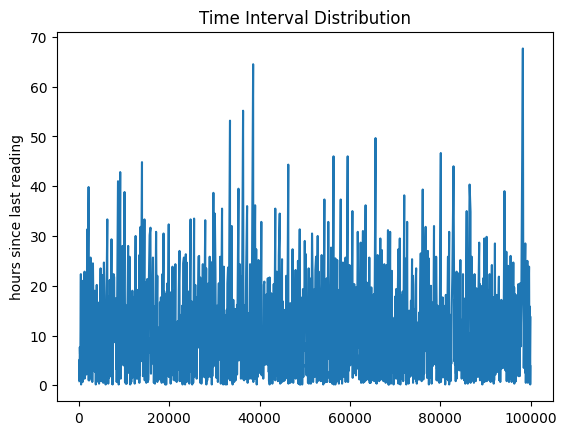

In [138]:
# Plot time intervals for one machine

sample_machine = machine_data[machine_data['Machine_ID'] == 1]
time_diffs = sample_machine['Timestamp'].diff().dt.total_seconds() / 360  # in hours

plt.plot(time_diffs)
plt.Figure(figsize=(100,10))
plt.ylabel('hours since last reading')
plt.title('Time Interval Distribution')
plt.show()

In [140]:
time_diffs.mean()

np.float64(8.68798955613577)

In [8]:
# One-hot encode the categorical column
operation_mode_dummies = pd.get_dummies(machine_data['Operation_Mode'], prefix='op_mode')

# Concatenate with original data (drop original column)
machine_data = pd.concat([machine_data.drop('Operation_Mode', axis=1), operation_mode_dummies], axis=1)

In [9]:
machine_data.columns

Index(['Timestamp', 'Machine_ID', 'Temperature_C', 'Vibration_Hz',
       'Power_Consumption_kW', 'Network_Latency_ms', 'Packet_Loss_%',
       'Quality_Control_Defect_Rate_%', 'Production_Speed_units_per_hr',
       'Predictive_Maintenance_Score', 'Error_Rate_%', 'Efficiency_Status',
       'op_mode_Active', 'op_mode_Idle', 'op_mode_Maintenance'],
      dtype='object')

In [17]:
machine_data['hour'] = machine_data['Timestamp'].dt.hour

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_sequences(df, timesteps=20, test_size=0.2, random_state=42):
    X_train, X_test = [], []
    y_train, y_test = [], []
    machine_train, machine_test = [], []
    
    for machine_id in df['Machine_ID'].unique():
        machine_data = df[df['Machine_ID'] == machine_id].sort_values('Timestamp')
        features = machine_data.drop(columns=['Machine_ID', 'Timestamp', 'Predictive_Maintenance_Score', 
                                            'Efficiency_Status', 'Quality_Control_Defect_Rate_%', 'Error_Rate_%'])
        target = machine_data['Predictive_Maintenance_Score'].values
        
        # Scale features per-machine
        scaler = MinMaxScaler()
        scaled_features = scaler.fit_transform(features)
        
        # Create sequences for this machine
        sequences = []
        targets = []
        for i in range(timesteps, len(machine_data)):
            sequences.append(scaled_features[i-timesteps:i])
            targets.append(target[i])
        
        # Split this machine's sequences into train/test
        if len(sequences) > 1:  # Only split if we have enough sequences
            X_machine_train, X_machine_test, y_machine_train, y_machine_test = train_test_split(
                np.array(sequences),
                np.array(targets),
                test_size=test_size,
                shuffle=False,  # Maintain temporal order
                random_state=random_state
            )
            
            X_train.extend(X_machine_train)
            X_test.extend(X_machine_test)
            y_train.extend(y_machine_train)
            y_test.extend(y_machine_test)
            machine_train.extend([machine_id] * len(X_machine_train))
            machine_test.extend([machine_id] * len(X_machine_test))
    
    return (
        np.array(X_train), np.array(X_test),
        np.array(y_train), np.array(y_test),
        np.array(machine_train), np.array(machine_test)
    )

# Usage
X_train, X_test, y_train, y_test, machine_train, machine_test = create_sequences(machine_data)

In [77]:
X_train.shape

(79020, 24, 10)

In [164]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# 1. Convert machine IDs to integers
le = LabelEncoder()
machine_train_ids = le.fit_transform(machine_train)
machine_test_ids = le.transform(machine_test)

# 2. Build the GRU model
def build_gru_model(num_machines=50, timesteps=20, num_features=10):
    # Time series input
    ts_input = Input(shape=(timesteps, num_features), name='ts_input')
    
    # Machine ID input
    machine_input = Input(shape=(1,), name='machine_input', dtype='int32')
    
    # GRU layers
    x = GRU(128, return_sequences=True)(ts_input)
    x = GRU(64)(x)
    
    # Machine embedding
    machine_embed = Embedding(input_dim=num_machines, output_dim=12)(machine_input)
    machine_embed = Flatten()(machine_embed)
    
    # Combine features
    combined = Concatenate()([x, machine_embed])
    
    # Output
    output = Dense(1, activation='sigmoid')(combined)
    
    model = Model(inputs=[ts_input, machine_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0025),
                 loss='mse',
                 metrics=['mae'])
    return model

# 3. Initialize and train model
model = build_gru_model(timesteps=X_train.shape[1], 
                       num_features=X_train.shape[2])

history = model.fit(
    x=[X_train, machine_train_ids],
    y=y_train,
    validation_data=([X_test, machine_test_ids], y_test),
    batch_size=64,
    epochs=50,
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss')
    ],
    verbose=1,   
)



Epoch 1/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 0.0838 - mae: 0.2505 - val_loss: 0.0834 - val_mae: 0.2500
Epoch 2/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0835 - mae: 0.2503 - val_loss: 0.0835 - val_mae: 0.2502
Epoch 3/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - loss: 0.0832 - mae: 0.2496 - val_loss: 0.0835 - val_mae: 0.2501
Epoch 4/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - loss: 0.0833 - mae: 0.2499 - val_loss: 0.0835 - val_mae: 0.2501
Epoch 5/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0832 - mae: 0.2495 - val_loss: 0.0835 - val_mae: 0.2502
Epoch 6/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 0.0834 - mae: 0.2501 - val_loss: 0.0835 - val_mae: 0.2502
Epoch 7/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0831 - mae: 0.2492 - val_loss: 0.0839 - val_mae: 0.2506
Epoch 8/50
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - loss: 0.0833 - mae: 0.2499 - val_loss: 0.0834 - val_mae: 0.2501
Epoch 9/50
1238/1238 ━━━

In [165]:
# 4. Evaluate
test_loss, test_mae = model.evaluate([X_test, machine_test_ids], y_test)
print(f"\nTest MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0831 - mae: 0.2498

Test MSE: 0.0834, Test MAE: 0.2500


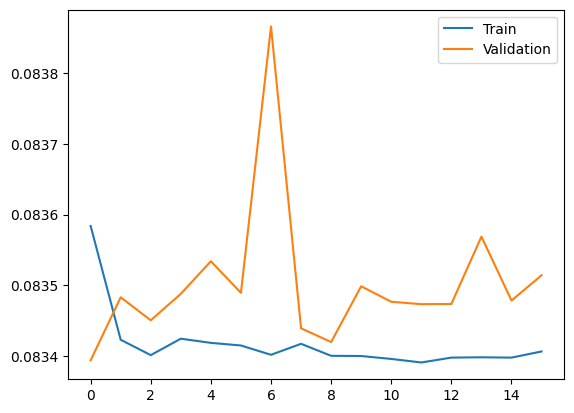

In [166]:
# Check loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()
